<img src="images/cads-logo.png" style="height: 100px;" align=left> <img src="images/sklearn-logo.png" style="height: 100px;" align=right>
# Machine Learning 

# Day5:  In Depth: Principal Component Analysis

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

We begin with the standard imports:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

Let's have a look at this short video explaining the intuition behind PCA. [A Layman's introduction to PCA](https://www.youtube.com/watch?v=BfTMmoDFXyE)

## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

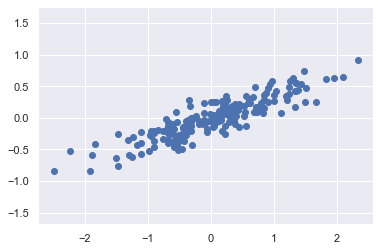

In [4]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

### Standardize the Data
PCA is effected by scale so you need to scale the features in the data before applying PCA. You can transform the data onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. `StandardScaler` helps standardize the dataset’s features.

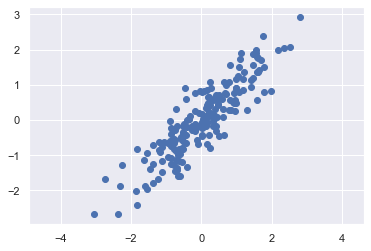

In [5]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)
plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables.
This is reminiscent of the linear regression data we explored in `Linear Regression` session, but the problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_Scaled)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [7]:
print(pca.components_)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


In [8]:
pca.mean_

array([-3.10862447e-17,  0.00000000e+00])

#### explained variance
The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this.

In [9]:
print(pca.explained_variance_)

[1.89888438 0.11116588]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

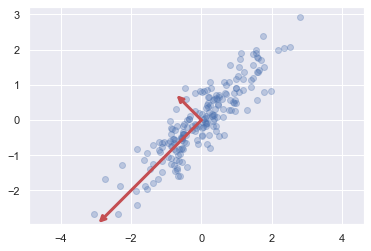

In [10]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=3,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector* np.sqrt(length)*3
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

If we plot these principal components beside the original data, we see the plots shown here:

![](images/05.09-PCA-rotation.png)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Principal-Components-Rotation)

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [13]:
pca = PCA(n_components=1)
pca.fit(X_Scaled)
X_pca = pca.transform(X_Scaled)
print("original shape:   ", X_Scaled.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

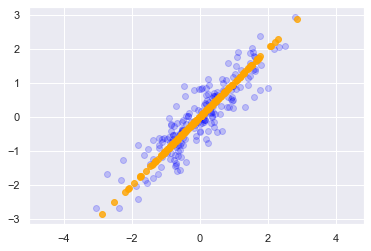

In [12]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], alpha=0.2, c='blue')
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, c='orange')
plt.axis('equal');

The blue points are the original data, while the orange points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.

The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### Visualizing high-dimensional data

One of the most common applications of PCA is visualizing high-dimensional datasets. The following code tries to visualize the cancer dataset. 

In [14]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
cancer.data[:3,:]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [15]:
cancer.data.shape

(569, 30)

As this dataset has 30 features, we can draw scatterplots of all two by two features or histogram of each feature. But the number of two by two combinations of 30 features will result in 435 plots! We would never be able to look at these plots in detail, let alone try understanding and analyzing them.

One way to visualize the separation between the classes is by computing histograms of each of the features for the two classes -- benign and malignant cancer. This is a simple way to see which features are likely to be able to separate the two classes well. 

Here we create a histogram for each of the features. Each histogram counts how often a data point appears with a feature in a certain range (called a *bin*). Each plot overlays two histograms, one for all the points in the benign class (green) and one for all the points in the malignant class (blue). This gives us some idea of how each feature is distributed across the two classes and allows us to make a guess as to which features are better at distinguishing malignant and benign samples. For example, "smoothness error" seems quite uninformative while the feature "worst concave points" seems quite useful because we can tell apart the two classes with little overlap between them.

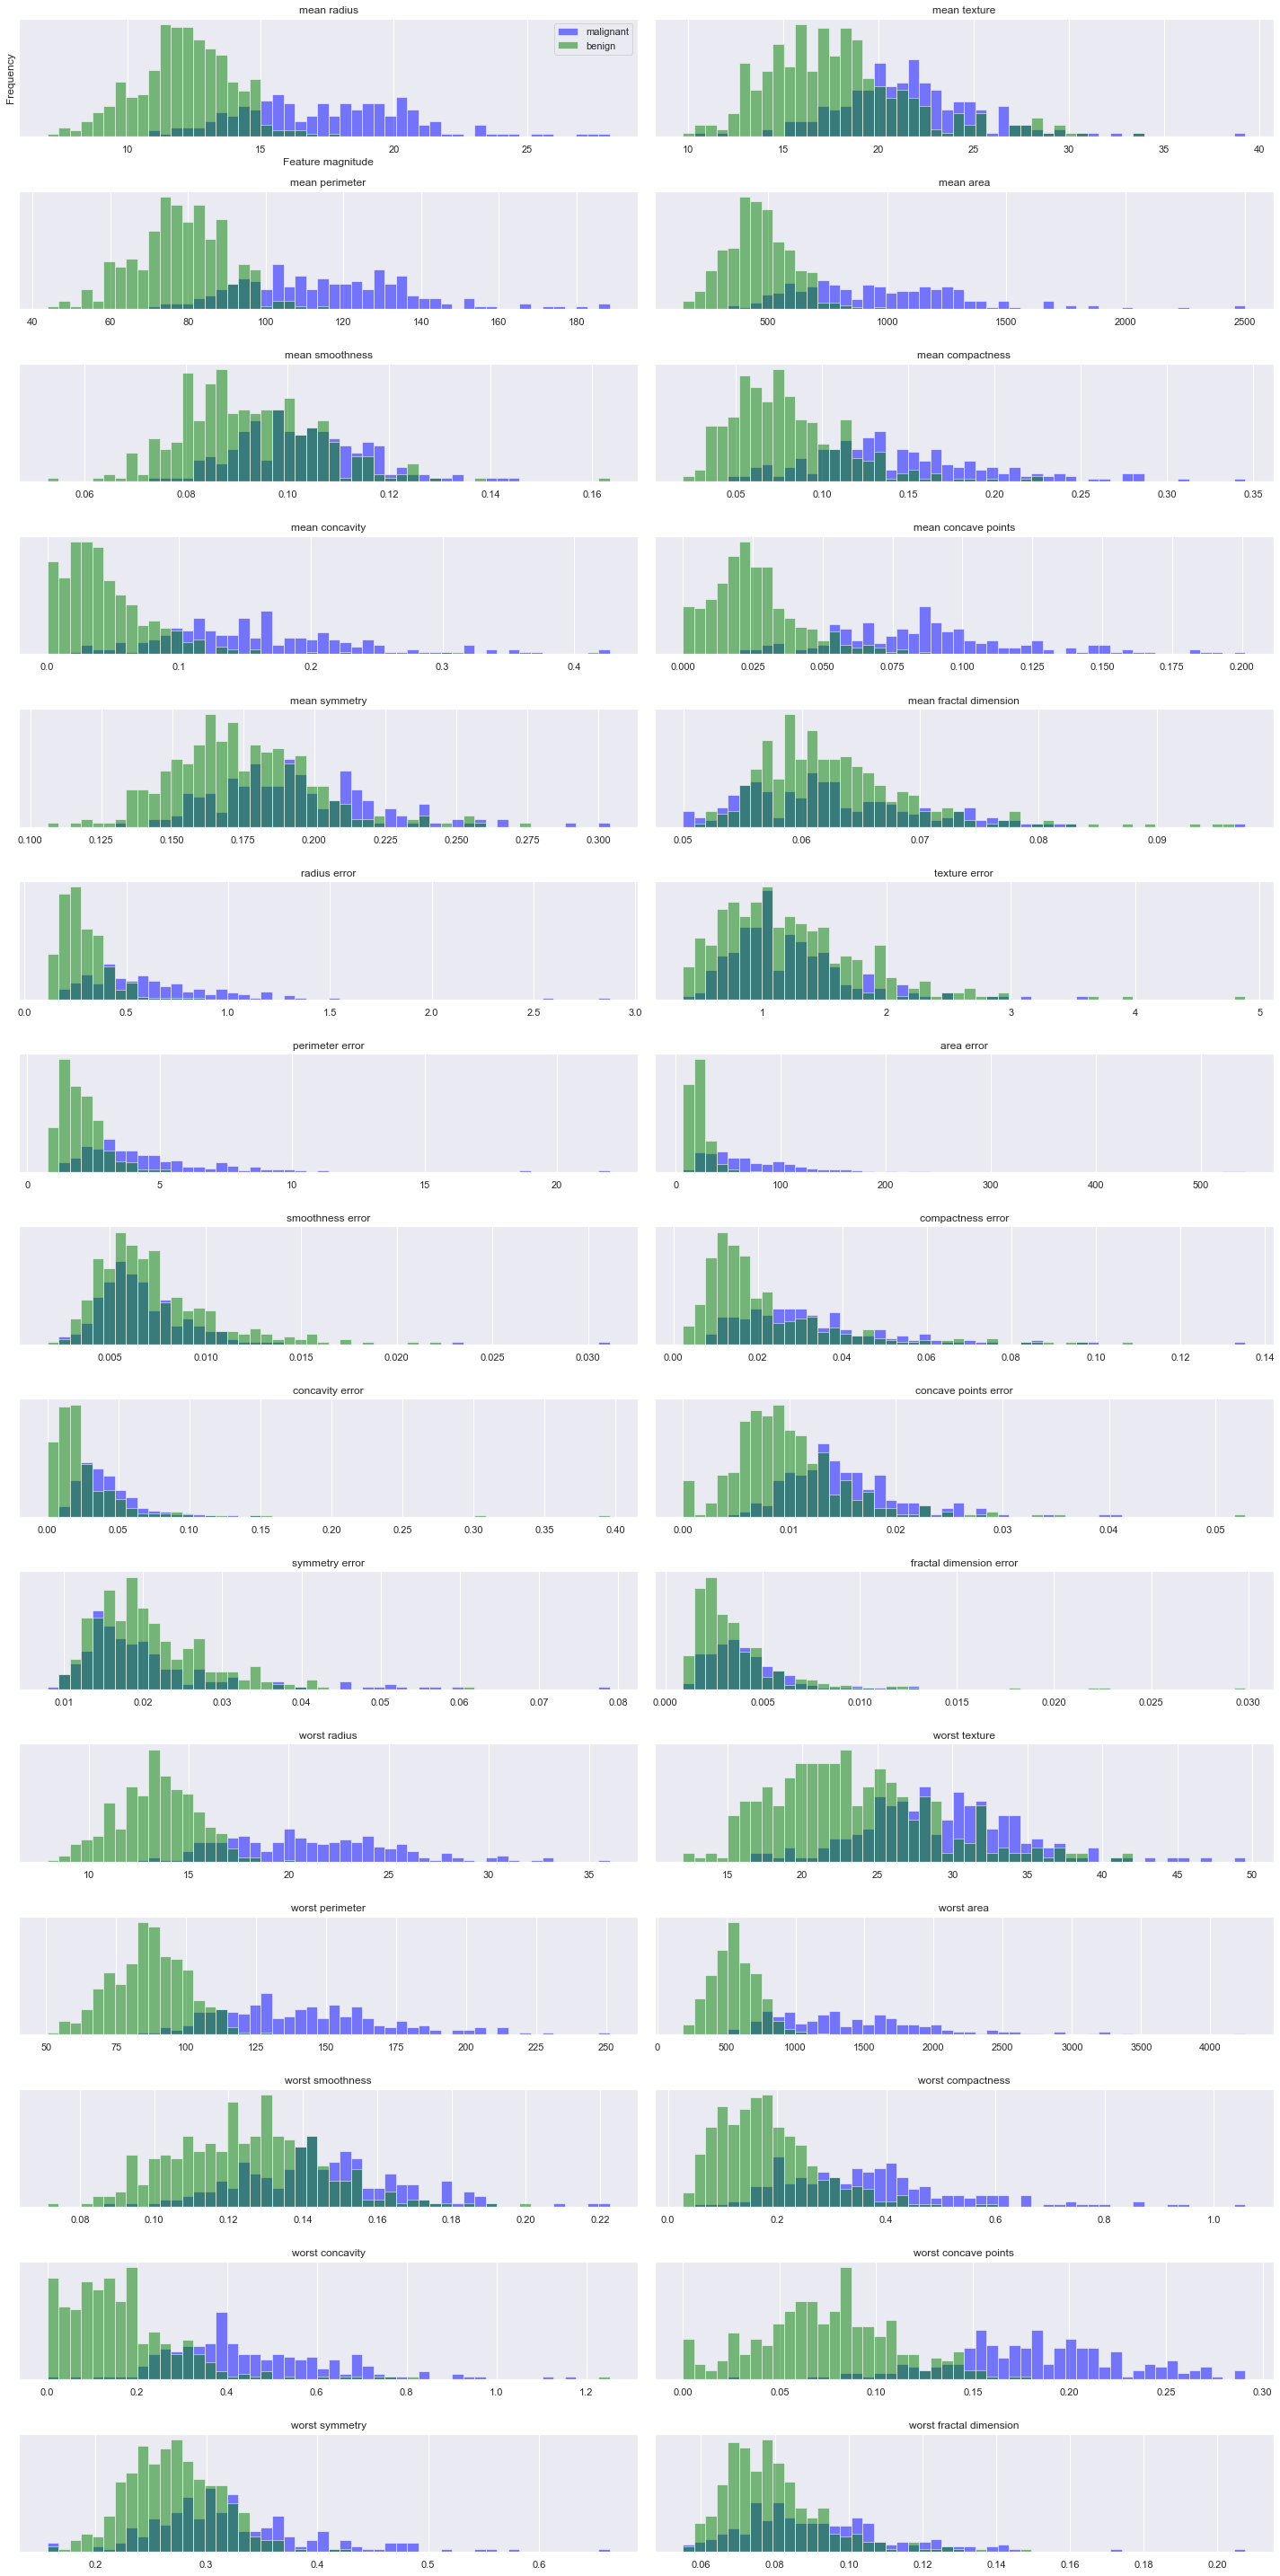

In [16]:
fig, axes = plt.subplots(15, 2, figsize=(20, 40))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color='blue', alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color='green', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())

ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()
plt.show()

By using PCA, we can capture the main interactions between these variables and get a more complete picture. We can find the first two principal components (at least visually possible) and visualize the data in this new two-dimensional space with a single scatter plot. Before we apply PCA, let's also scale our data with `StandardScaler` so that each feature has unit variance:

In [17]:
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Learning the PCA transformation and applying it is as simple as applying a preprocessing transformation. We instantiate the `PCA` object, find the principal components by calling the `fit()` method, and then apply the rotation and dimensionality reduction by calling `transform()`. (You can call both together thru `fit_transform()`.) 

As usual PCA rotates (and shifts) the data, but keeps all principal components. To reduce the dimensionality of the data, we need to specify how many components we want to keep when creating the PCA object:

In [18]:
X_scaled.shape

(569, 30)

In [19]:
# keep the first two principal components of the data
pca = PCA(n_components=2)

# fit PCA model to breast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


In [20]:
print(pca.components_)

[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


In [21]:
print(pca.mean_)
print(pca.mean_.shape)

[-3.16286735e-15 -6.53060890e-15 -7.07889127e-16 -8.79983452e-16
  6.13217737e-15 -1.12036918e-15 -4.42138027e-16  9.73249991e-16
 -1.97167024e-15 -1.45363120e-15 -9.07641468e-16 -8.85349205e-16
  1.77367396e-15 -8.29155139e-16 -7.54180940e-16 -3.92187747e-16
  7.91789988e-16 -2.73946068e-16 -3.10823423e-16 -3.36676596e-16
 -2.33322442e-15  1.76367415e-15 -1.19802625e-15  5.04966114e-16
 -5.21317026e-15 -2.17478837e-15  6.85645643e-16 -1.41265636e-16
 -2.28956670e-15  2.57517109e-15]
(30,)


In [22]:
print(X_pca.shape)
X_pca

(569, 2)


array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       ...,
       [ 1.25617928, -1.90229671],
       [10.37479406,  1.67201011],
       [-5.4752433 , -0.67063679]])

You can now plot the first two principal components:

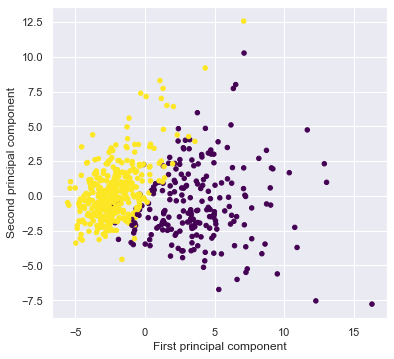

In [23]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cancer.target, cmap='viridis', s=20)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

It is important to note that PCA is an unsupervised method, and does not use any class information when finding the rotation. It simply looks at the correlations in the data. For the scatter plot shown here, we plotted the first principal component against the second principal component, and then used the class information to color the points (class information was never used to learn this distribution). You can see that the two classes separate quite well in this 2-D space. This leads us to believe that even a linear classifier (that would learn a line in this space) could do a reasonably good job at distinguishing the two classes. We can also see that the malignant (purple) points are more spread out than the benign (yellow) points, something that we could already see a bit from the histograms earlier.

A downside of PCA is that the two axes in the plot are often not very easy to interpret. The principal components correspond to directions in the original data, so they are *combinations of the original features*. However, these combinations are usually very complex.

### Dissecting PCA

Let's take a look at what makes this PCA work.

In [24]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


Each row in `components_` corresponds to one principal component, and they are sorted by their importance (the first principal component comes first, and etc.). The columns correspond to the original features attribute of the PCA in this example, "mean
radius", "mean texture", and so on. Recall, there were 30 of them. Let's have a look at the content of `components_`:

In [25]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


We can also visualize the coefficients using a heatmap, which might be easier to understand:

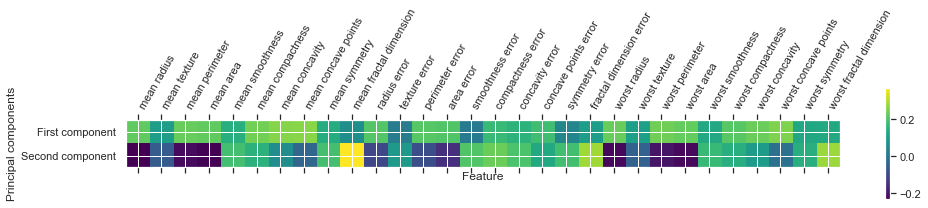

In [26]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

In [27]:
pca.explained_variance_

array([13.30499079,  5.7013746 ])

You can see that in the first component, all features have the same sign (all positive, but it actually doesn't matter which direction). That means that there is a general correlation between all features. As one measurement is high, the others are likely to be high as well. The second component has mixed signs, and both of the components involve all of the 30 features. This mixing of features is what makes explaining the earlier axes tricky.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data we saw in [ML13 Decision Trees and Random Forests](ML13_Decision_Tree_Random_Forests.ipynb).

We start by loading the data:

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [29]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

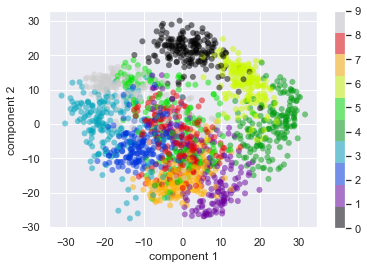

In [30]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

![](images/05.09-digits-pixel-components.png)


The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1^{\prime} \cdot{\rm (basis~1)} + x_2^{\prime} \cdot{\rm (basis~2)} + x_3^{\prime} \cdot{\rm (basis~3)} \cdots + x_8^{\prime} \cdot{\rm (basis~8)}
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

![](images/05.09-digits-pca-components.png)


Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

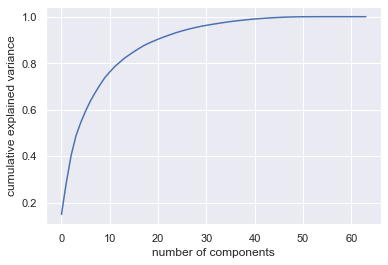

In [31]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

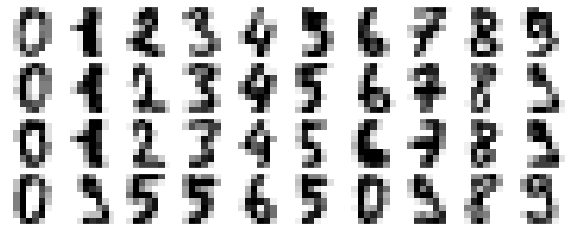

In [32]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

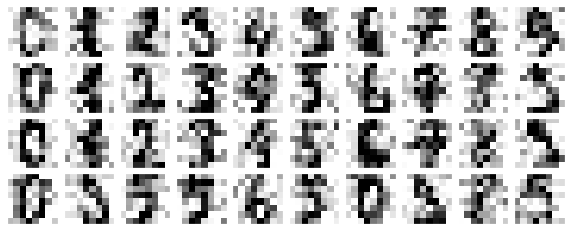

In [33]:
np.random.seed(42)
noisy = np.random.normal(digits.data, scale=4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [34]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

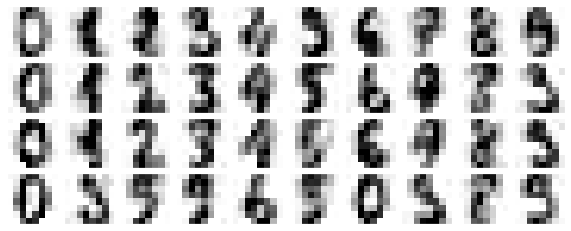

In [39]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

## Example: Eigenfaces



 We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [40]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Junichiro Koizumi']
(820, 62, 47)


Let's plot a few of these faces to see what we're working with:

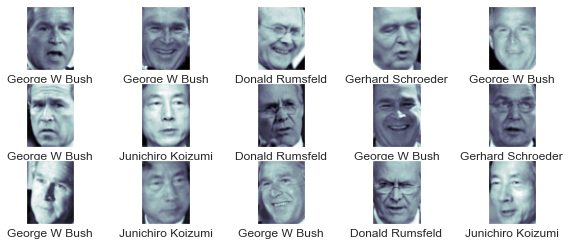

In [44]:
fig, ax = plt.subplots(3, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use ``RandomizedPCA``—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [46]:
# pca without scaling
from sklearn.decomposition import PCA

pca = PCA(150, svd_solver='randomized').fit(faces.data)     # just select 150 features

In [47]:
# pca with scaling
from sklearn.decomposition import PCA
scaler = StandardScaler()
faces.data_scaled=scaler.fit_transform(faces.data)
pca_scaled = PCA(150, svd_solver='randomized').fit(faces.data_scaled)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors,"
so these types of images are often called "eigenfaces").
As you can see in this figure, they are as creepy as they sound:

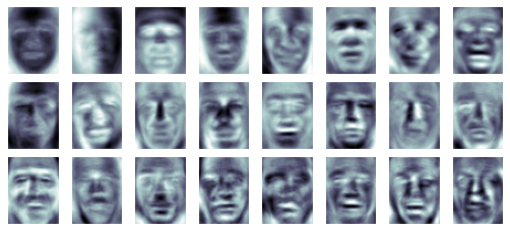

In [48]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_scaled.components_[i].reshape(62, 47), cmap='bone')

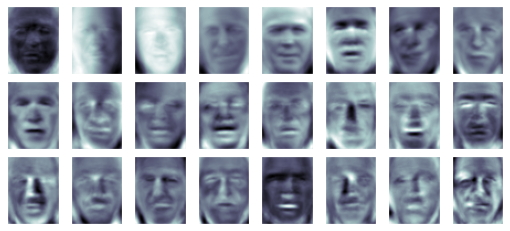

In [49]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

In [51]:
pca.components_

array([[-1.1095514e-02, -1.1260738e-02, -1.1350466e-02, ...,
        -5.7170391e-03, -4.8999735e-03, -4.2688265e-03],
       [ 1.5199972e-02,  1.5087279e-02,  1.5543625e-02, ...,
        -3.1445090e-02, -2.9989962e-02, -2.8829895e-02],
       [-1.4865385e-02, -1.3393758e-02, -1.3018820e-02, ...,
        -3.8831182e-02, -3.4604084e-02, -3.2028303e-02],
       ...,
       [-4.2209927e-02, -2.1664038e-02,  1.6567389e-02, ...,
         9.4028246e-03, -7.5764367e-03, -4.8546765e-02],
       [-9.2539089e-03, -2.7126613e-05,  2.0921340e-02, ...,
        -4.2416029e-02,  8.2838181e-03,  4.8388366e-02],
       [-1.6278930e-02, -2.1593625e-02, -8.4930882e-03, ...,
         2.3288153e-02,  2.2728814e-02,  2.3319473e-02]], dtype=float32)

In [60]:
# Make and plot a new face by selecting some components and useing your own coefficients 
plt.imshow((6 * pca.components_[2] + ((-1) * pca.components_[10] + 10 *
            pca.components_[4] + 100 * pca.components_[21]).reshape(62, 47) , cmap='bone')

SyntaxError: invalid syntax (Temp/ipykernel_7964/1504295285.py, line 3)

In [61]:
# Make and plot a new face by selecting some components and useing your own coefficients 
plt.imshow((6 * pca.components_[2] + ((-1) * pca.components_[10] + 10 *
            pca.components_[4] + 100 * pca.components_[21]).reshape(62, 47) , cmap='bone')

SyntaxError: invalid syntax (Temp/ipykernel_7964/1504295285.py, line 3)

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

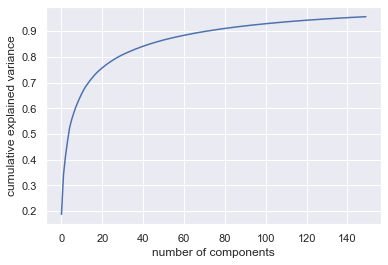

In [62]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

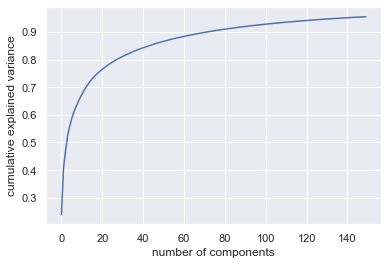

In [55]:
plt.plot(np.cumsum(pca_scaled.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [63]:
# Compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

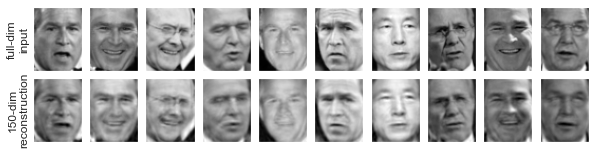

In [64]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

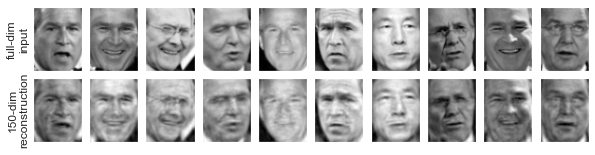

In [65]:
pca_scaled = PCA(150, svd_solver='randomized').fit(faces.data_scaled)
components_scaled = pca_scaled.transform(faces.data)
projected_scaled = pca_scaled.inverse_transform(components_scaled)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected_scaled[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

### Exercise:

Change the above plot so that we can see three rows of faces: input, transformed with PCA without scaling, and with scaling.

In [ ]:
# your code here

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.

With this visualization we can guess that the PCA feature selection would be successful for image classification: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.
What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

### Exercise

- Train SVM with linear kernel, LogisticRegression, KNN, Naibe Bayes and Decision tree classifiers on this dataset. With and without dimensionality reduction.
- What is the accuracy obtained on the test set?
- Show the classification report
- Show the confusion matrix 

In [66]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [67]:
# your code here
pca = PCA(150, svd_solver="randomized").fit(faces.data_scaled)
Xtrain_pca = pca.transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

In [68]:
print(Xtrain.shape)
print(Xtrain_pca.shape)

(615, 2914)
(615, 150)


In [ ]:
svc
lr
knn
nb
dt

### Exercise

- Train a logistic regression on the breast cancer data
- Divide the data into train and test
- Train and test the logistic regression. what are the train and test scores?
- Scaled the data with standard scaler. what are the train and test scores?
- Reduce the amount of features using pca. Try different settings for n_components. Are you able to get an increase in test score? what is explanation of this?
- Plot the cummulative explained variance ratio

In [ ]:
from sklearn.datasets import load_breast_cancer

In [69]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
X.shape

(569, 30)

In [72]:
# your code here
logreg = LogisticRegression(fit_intercept=True)

logreg.fit(Xtrain, ytrain)
y_pred = logreg.predict(Xtest)
print('train score: ', logreg.score(Xtrain, ytrain))

NameError: name 'LogisticRegression' is not defined

## Principal Component Analysis Summary

In this section we have discussed the use of principal component analysis for dimensionality reduction, for visualization of high-dimensional data, for noise filtering, and for feature selection within high-dimensional data.
Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines.
Given any high-dimensional dataset, one can start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio).
Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data.
For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.
Scikit-Learn contains a couple interesting variants on PCA, including ``RandomizedPCA`` and ``SparsePCA``, both also in the ``sklearn.decomposition`` submodule.
``PCA(svd_solver='randomized')``, which we saw earlier, uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while ``SparsePCA`` introduces a regularization term that serves to enforce sparsity of the components.

### Limitation

Doesn't work on sparse matrix.

Use [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) if you have sparse matrix.

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="images/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

### Videos:

- https://www.youtube.com/watch?v=Zbr5hyJNGCs
